In [15]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import pickle
from agents.classes import *
import json
from agents import *

In [71]:
replay = open("replays/1-agents-2019-11-16 19_26_48.541701.json",'rt')
obs = json.load(replay)
replay.close()

In [72]:
len(obs["steps"])

548

In [73]:
grid = np.array(obs["steps"][0]["state"]["grid"], dtype=float)

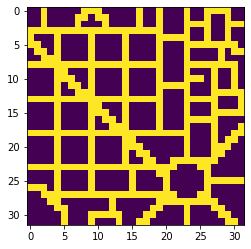

In [74]:
imshow(grid)

In [75]:
# Let's write a massive function to parse this thing
def parse_car(c):
    return Car(c["id"], c["position"], c["capacity"], c["available_capacity"], c["customers"])
def parse_team(t):
    cars = []
    for c in t["cars"]:
        cc = parse_car(c)
        cars.append(cc)
    return Team(t["id"], t["name"], cars, t["score"])
def parse_customer(c):
    return Customer(c['id'], c['position'], c['destination'])
def parse_state(s):
    customers = []
    teams = []
    for c in s["customers"]:
        cc = parse_customer(c)
        customers.append(cc)
    for t in s["teams"]:
        tt = parse_team(t)
        teams.append(tt)
    return State(s["grid"], teams, customers, s["ticks"])
def parse_actions(acc):
    actions = []
    for a in acc:
        ac = Action(a["car_id"], a["direction"])
        actions.append(ac)
    return actions
def parse_step(s):
    acts = []
    st = parse_state(s["state"])
    for ac in s["acts"]:
        acc = {
            "team": ac["team"],
            "actions": parse_actions(ac["actions"])
        }
        acts.append(acc)
    step = {
        "state": st,
        "acts": acts
    }
    return step
def parse_replay(rep):
    steps = []
    for s in rep["steps"]:
        ss = parse_step(s)
        steps.append(ss)
    config = rep["config"]
    return {
        "steps": steps,
        "config": config
    }

In [76]:
rep = parse_replay(obs)

In [77]:
rep["steps"][0]["state"].teams[0].id

'0'

In [78]:
def get_other_cars_map(state, team_id, size):
    non_teams = []
    for t in state.teams:
        if t.id != team_id:
            non_teams.append(t)
    grid = np.zeros(size, dtype=np.float)
    for t in non_teams:
        for c in t.cars:
            grid[c.position[1], c.position[0]] = 1
    return grid

In [79]:
width = len(rep["steps"][0]["state"].grid)
size = (width, width)

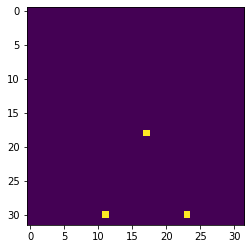

In [80]:
imshow(get_other_cars_map(rep["steps"][0]["state"], '1',size))

In [111]:
def Astar(start, dest, grid):
    directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]

    pq = PriorityQueue()
    pq.push(start, 0)

    parent = {}
    cost = {}
    parent[start] = None
    cost[start] = 0

    while not pq.is_empty():
        curr = pq.pop()

        if curr == dest:
            break

        for dir in directions:
            neighbor = add(curr, dir)
            if neighbor[0] < 0:
                continue
            if neighbor[0] >= len(grid): #TODO
                continue
            if neighbor[1] < 0:
                continue
            if neighbor[1] >= len(grid[0]): #TODO
                continue
            if grid[neighbor[1]][neighbor[0]] == False:
                continue

            n_cost = cost[curr] + 1
            if neighbor not in cost.keys() or n_cost < cost[neighbor]:
                cost[neighbor] = n_cost
                priority = n_cost + heuristic(neighbor, dest)
                pq.push(neighbor, priority)
                parent[neighbor] = curr

    if dest not in parent.keys():
        return None, None
        
    if dest == start:
        return None, None

    prev = dest
    targ = None
    route = []
    while not prev == start:
        route = [prev] + route
        targ = prev
        prev = parent[prev]
    return route, cost[dest]
def add(x, y):
    s1 = x[0] + y[0]
    s2 = x[1] + y[1]
    return (s1, s2)
def heuristic(pos1, pos2):
    (x1, y1) = pos1
    (x2, y2) = pos2
    return abs(x1 - x2) + abs(y1 - y2)

In [114]:
def get_available_customers(state, size):
    grid = np.zeros(size, dtype=np.float)
    customers_in_cars = []
    for t in state.teams:
        for c in t.cars:
            customers_in_cars += c.customers
    for c in state.customers:
        route, distance = Astar(tuple(c.position), tuple(c.destination), state.grid)
        if distance is not None:
            grid[c.position[1], c.position[0]] = 1 * (distance / 10)
        else:
            grid[c.position[1], c.position[0]] = 1
        if route is not None:
            for r in route:
                grid[r[1], r[0]] = 0.5
        grid[c.destination[1], c.destination[0]] = -1
    return grid

In [116]:
customer_map = get_available_customers(rep["steps"][22]["state"], size)

In [117]:
np.max(customer_map)

4.2

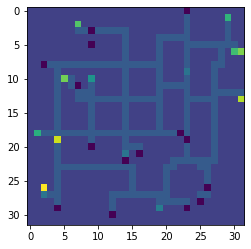

In [118]:
imshow(customer_map)

In [120]:
def get_my_cars_map(state, team_id, size):
    my_cars = []
    def get_customer_from_id(id):
        for c in state.customers:
            if c.id == id:
                return c
    for t in state.teams:
        if t.id == team_id:
            for c in t.cars:
                my_cars.append(c)
    grids = [np.zeros(size, dtype=np.float) for _ in range(len(my_cars))]
    for c, g in zip(my_cars, grids):
        for cust_id in c.customers:
            cust = get_customer_from_id(cust_id)
            g[cust.destination[1], cust.destination[0]] = -1
        g[c.position[1], c.position[0]] = 1
    return grids

In [121]:
grids = get_my_cars_map(rep["steps"][22]["state"], '0', size)

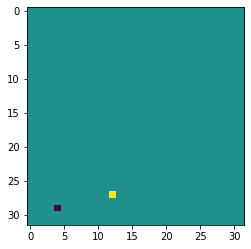

In [131]:
imshow(grids[1])